In [1]:
# =========================================================
# Experiment 1 — Logistic Regression with Correct Preprocessing
# =========================================================

import pandas as pd
import numpy as np

from custom_transformers import Log1pTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_experiment("Final_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast categorical columns to string BEFORE training
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align body system column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Column groups ----------
numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

# ---------- Log transformer ----------
class Log1pTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)

log_transformer = Log1pTransformer()

# ---------- Preprocessing Pipeline ----------
preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log", Pipeline([
            ("log", log_transformer),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------------------------------------------------------
# Experiment 1 Runner (Logistic Regression ONLY)
# ---------------------------------------------------------
def run_experiment_1():
    with mlflow.start_run(run_name="Experiment_1_LogReg"):

        estimator = LogisticRegression(max_iter=500)

        param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        }

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("clf", estimator)
        ])

        model = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,
            scoring="f1",
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        best_est = model.best_estimator_

        mlflow.log_params(model.best_params_)

        cv10 = cross_validate(best_est, X_train, y_train, cv=10, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv10["test_score"].mean())
        mlflow.log_metric("cv10_f1_std", cv10["test_score"].std())

        y_pred_train = best_est.predict(X_train)
        y_pred_test = best_est.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_train).ravel()
        tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_pred_test).ravel()

        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("train_TP", tp_tr)
        mlflow.log_metric("train_TN", tn_tr)
        mlflow.log_metric("train_FP", fp_tr)
        mlflow.log_metric("train_FN", fn_tr)

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp_te)
        mlflow.log_metric("test_TN", tn_te)
        mlflow.log_metric("test_FP", fp_te)
        mlflow.log_metric("test_FN", fn_te)

        mlflow.sklearn.log_model(best_est, "Experiment_1_LogReg_Model")

    print(f"✅ Experiment 1 complete | Train F1={f1_train:.3f} | Test F1={f1_test:.3f}")

run_experiment_1()

Accessing as menna1996

Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

2025/12/16 21:58:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Experiment_1_LogReg at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/95541e1eeea542e884d6fe36788995fb
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Experiment 1 complete | Train F1=0.840 | Test F1=0.841


In [2]:
# =========================================================
# Experiment 2 — Multiple Classifiers with Correct Preprocessing
# =========================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_experiment("Final_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast categorical columns to string BEFORE training
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align BodySystem column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Column groups ----------
numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

# ---------- Log transformer ----------
class Log1pTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)

log_transformer = Log1pTransformer()

# ---------- Preprocessing Pipeline ----------
base_preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log", Pipeline([
            ("log", log_transformer),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------------------------------------------------------
# Generic Experiment Runner
# ---------------------------------------------------------
def run_experiment(
    name: str,
    estimator,
    param_grid: dict = None,
    preprocessor=base_preprocessor,
    cv_folds: int = 10,
):
    with mlflow.start_run(run_name=name):

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("clf", estimator)
        ])

        if param_grid:
            model = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                cv=3,
                scoring="f1",
                n_jobs=-1
            )
        else:
            model = pipeline

        model.fit(X_train, y_train)
        best_est = model.best_estimator_ if isinstance(model, GridSearchCV) else model

        if isinstance(model, GridSearchCV):
            mlflow.log_params(model.best_params_)

        # Cross-validation
        cv10 = cross_validate(best_est, X_train, y_train, cv=cv_folds, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv10["test_score"].mean())
        mlflow.log_metric("cv10_f1_std", cv10["test_score"].std())

        # Train/Test evaluation
        y_pred_train = best_est.predict(X_train)
        y_pred_test = best_est.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)

        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_train).ravel()
        tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_pred_test).ravel()

        # Log metrics
        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("train_TP", tp_tr)
        mlflow.log_metric("train_TN", tn_tr)
        mlflow.log_metric("train_FP", fp_tr)
        mlflow.log_metric("train_FN", fn_tr)

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp_te)
        mlflow.log_metric("test_TN", tn_te)
        mlflow.log_metric("test_FP", fp_te)
        mlflow.log_metric("test_FN", fn_te)

        mlflow.sklearn.log_model(best_est, f"{name}_model")

    print(f"✅ {name} complete | Train F1={f1_train:.3f} | Test F1={f1_test:.3f}")

# ---------------------------------------------------------
# Import Models
# ---------------------------------------------------------
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ---------------------------------------------------------
# Run Experiment 2 Models
# ---------------------------------------------------------

run_experiment(
    name="Exp2_LogReg",
    estimator=LogisticRegression(max_iter=500),
    param_grid={
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    }
)

run_experiment(
    name="Exp2_Ridge",
    estimator=RidgeClassifier(),
    param_grid={
        "clf__alpha": [0.1, 1.0, 10.0]
    }
)

run_experiment(
    name="Exp2_RandomForest",
    estimator=RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42),
    param_grid={
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }
)

run_experiment(
    name="Exp2_XGB",
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    ),
    param_grid={
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.05, 0.1]
    }
)

Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

2025/12/16 21:58:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp2_LogReg at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/7d9349eb7b7243b5a474cad9ed2e4a15
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp2_LogReg complete | Train F1=0.840 | Test F1=0.841


2025/12/16 21:58:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp2_Ridge at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/c089f1cd34de46119b00ced444b5c0cb
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp2_Ridge complete | Train F1=0.800 | Test F1=0.829


2025/12/16 21:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp2_RandomForest at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/e92be1f79f1b44faad517f56845551c7
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp2_RandomForest complete | Train F1=0.952 | Test F1=0.862


2025/12/16 21:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp2_XGB at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/027faf562ebe40dc9546471136d0c979
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp2_XGB complete | Train F1=0.923 | Test F1=0.848


In [3]:
# =========================================================
# Experiment 3 — Feature Engineering & Attribute Combination (Corrected)
# =========================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_experiment("Final_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast base categorical columns to string BEFORE feature engineering
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align BodySystem column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

# ---------- Feature Engineering ----------
df_fe = df.copy()

# 1. Cost buckets
bins = [0, 100, 500, 2000, 10000, np.inf]
labels = ["0-100", "100-500", "500-2000", "2000-10000", "10000+"]
df_fe["total_paid_bucket"] = pd.cut(df_fe["total_paid_amt"], bins=bins, labels=labels)

# 2. Age groups
age_bins = [0, 40, 65, 80, np.inf]
age_labels = ["<60", "60-70", "70-80", "80+"]
df_fe["AGE_GROUP"] = pd.cut(df_fe["AGE_AT_END_REF_YR"], bins=age_bins, labels=age_labels)

# ✅ FIX 3: Cast engineered categorical features to string
df_fe["total_paid_bucket"] = df_fe["total_paid_bucket"].astype(str)
df_fe["AGE_GROUP"] = df_fe["AGE_GROUP"].astype(str)

# 3. Interaction term
df_fe["age_cost_interaction"] = df_fe["AGE_AT_END_REF_YR"] * df_fe["total_paid_amt"]

# 4. Body system count
df_fe["body_system_count"] = df_fe[body_system_cols].sum(axis=1)

# ---------- Train/Test Split ----------
X_fe = df_fe.drop(columns=["Avoidable_ED_Visit"])
y_fe = df_fe["Avoidable_ED_Visit"]

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)

# ---------- Updated Column Groups ----------
categorical_fe = categorical_cols + ["total_paid_bucket", "AGE_GROUP"]
numeric_extra = ["age_cost_interaction", "body_system_count"]

# ---------- Log transformer ----------
def log1p_transform(x):
    return np.log1p(x)

# ---------- Preprocessor ----------
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), ["AGE_AT_END_REF_YR"]),
        ("num_log_minmax", Pipeline([
            ("log", FunctionTransformer(log1p_transform)),
            ("minmax", MinMaxScaler())
        ]), ["total_paid_amt"]),
        ("num_extra", StandardScaler(), numeric_extra),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_fe),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------- Experiment 3 Runner ----------
def run_experiment_3(name, estimator, param_grid=None, cv_folds=10):
    with mlflow.start_run(run_name=name):

        pipeline = Pipeline(steps=[
            ("preprocess", preprocessor_fe),
            ("clf", estimator)
        ])

        if param_grid:
            model = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                cv=3,
                scoring="f1",
                n_jobs=-1
            )
        else:
            model = pipeline

        model.fit(X_train_fe, y_train_fe)
        best_est = model.best_estimator_ if isinstance(model, GridSearchCV) else model

        if isinstance(model, GridSearchCV):
            mlflow.log_params(model.best_params_)

        cv10 = cross_validate(best_est, X_train_fe, y_train_fe, cv=cv_folds, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv10["test_score"].mean())
        mlflow.log_metric("cv10_f1_std", cv10["test_score"].std())

        y_pred_train = best_est.predict(X_train_fe)
        y_pred_test = best_est.predict(X_test_fe)

        f1_train = f1_score(y_train_fe, y_pred_train)
        f1_test = f1_score(y_test_fe, y_pred_test)

        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train_fe, y_pred_train).ravel()
        tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test_fe, y_pred_test).ravel()

        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("train_TP", tp_tr)
        mlflow.log_metric("train_TN", tn_tr)
        mlflow.log_metric("train_FP", fp_tr)
        mlflow.log_metric("train_FN", fn_tr)

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp_te)
        mlflow.log_metric("test_TN", tn_te)
        mlflow.log_metric("test_FP", fp_te)
        mlflow.log_metric("test_FN", fn_te)

        mlflow.sklearn.log_model(best_est, f"{name}_model")

    print(f"✅ {name} complete | Train F1={f1_train:.3f} | Test F1={f1_test:.3f}")

# ---------- Run Experiment 3 ----------
run_experiment_3(
    name="Exp3_LogReg_with_FE",
    estimator=LogisticRegression(max_iter=500),
    param_grid={"clf__C": [0.01, 0.1, 1, 10]}
)

Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

2025/12/16 22:00:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp3_LogReg_with_FE at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/bc18090b3a3d4f148585f81f96021612
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp3_LogReg_with_FE complete | Train F1=0.848 | Test F1=0.854


In [4]:
# =========================================================
# Experiment 4 — Feature Selection (Corrected)
# =========================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import mlflow
import mlflow.sklearn
import dagshub

# ---------- DagsHub + MLflow ----------
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_experiment("Final_Project_Experiments")

# ---------- Load Data ----------
df = pd.read_parquet("modeling_dataset_clean.parquet")

# ✅ FIX 1: Cast categorical columns to string BEFORE training
categorical_cols = ["SEX_IDENT_CD", "BENE_RACE_CD", "YEAR"]
df[categorical_cols] = df[categorical_cols].astype(str)

# ✅ FIX 2: Align BodySystem column names with FastAPI
body_system_cols = [c for c in df.columns if c.lower().startswith("bodysystem_")]

X = df.drop(columns=["Avoidable_ED_Visit"])
y = df["Avoidable_ED_Visit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Column groups ----------
numeric_standard = ["AGE_AT_END_REF_YR"]
numeric_log = ["total_paid_amt"]

# ---------- Log transformer ----------
def log1p_transform(x):
    return np.log1p(x)

# ---------- Base Preprocessor ----------
base_preprocessor = ColumnTransformer(
    transformers=[
        ("num_standard", StandardScaler(), numeric_standard),
        ("num_log_minmax", Pipeline([
            ("log", FunctionTransformer(log1p_transform)),
            ("minmax", MinMaxScaler())
        ]), numeric_log),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("body", StandardScaler(), body_system_cols),
    ]
)

# ---------------------------------------------------------
# Experiment 4A — Variance Threshold
# ---------------------------------------------------------
from sklearn.feature_selection import VarianceThreshold

preprocessor_fs_var = ColumnTransformer(
    transformers=[
        ("num_standard", Pipeline([
            ("scaler", StandardScaler()),
            ("var", VarianceThreshold(threshold=0.0))
        ]), numeric_standard),

        ("num_log_minmax", Pipeline([
            ("log", FunctionTransformer(log1p_transform)),
            ("minmax", MinMaxScaler()),
            ("var", VarianceThreshold(threshold=0.0))
        ]), numeric_log),

        ("cat", Pipeline([
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ("var", VarianceThreshold(threshold=0.0))
        ]), categorical_cols),

        ("body", Pipeline([
            ("scaler", StandardScaler()),
            ("var", VarianceThreshold(threshold=0.0))
        ]), body_system_cols),
    ]
)

run_experiment(
    name="Exp4A_LogReg_VarianceThreshold",
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"clf__C": [0.01, 0.1, 1, 10]},
    preprocessor=preprocessor_fs_var
)

# ---------------------------------------------------------
# Experiment 4B — Correlation Threshold
# ---------------------------------------------------------
class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
            )
            self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        else:
            self.to_drop = []
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=self.to_drop, errors="ignore")
        return X

correlation_selector = CorrelationThreshold(threshold=0.9)

preprocessor_fs_corr = Pipeline([
    ("preprocess", base_preprocessor),
    ("corr", correlation_selector)
])

run_experiment(
    name="Exp4B_LogReg_CorrelationThreshold",
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"clf__C": [0.01, 0.1, 1, 10]},
    preprocessor=preprocessor_fs_corr
)

# ---------------------------------------------------------
# Experiment 4C — Feature Importance (RandomForest)
# ---------------------------------------------------------
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

importance_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=200, random_state=42),
    threshold="median"
)

preprocessor_fs_importance = Pipeline([
    ("preprocess", base_preprocessor),
    ("importance", importance_selector)
])

run_experiment(
    name="Exp4C_LogReg_FeatureImportance",
    estimator=LogisticRegression(max_iter=1000),
    param_grid={"clf__C": [0.01, 0.1, 1, 10]},
    preprocessor=preprocessor_fs_importance
)

Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

2025/12/16 22:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp4A_LogReg_VarianceThreshold at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/40f3438554814880a5435cb238d55015
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp4A_LogReg_VarianceThreshold complete | Train F1=0.840 | Test F1=0.841


c:\Users\bruck\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipe

🏃 View run Exp4B_LogReg_CorrelationThreshold at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/9db9e567b412468d82dbb96e4394fa23
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp4B_LogReg_CorrelationThreshold complete | Train F1=0.840 | Test F1=0.841


2025/12/16 22:01:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp4C_LogReg_FeatureImportance at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/91ff59477112431d9a1fde9c2c352687
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Exp4C_LogReg_FeatureImportance complete | Train F1=0.846 | Test F1=0.843


In [5]:
# ---------------------------------------------------------
# Experiment 6 — Custom Experiment: Threshold Tuning
# ---------------------------------------------------------
from sklearn.metrics import precision_recall_curve

def run_experiment_6():
    with mlflow.start_run(run_name="Exp6_LogReg_ThresholdTuning"):

        model = Pipeline(steps=[
            ("preprocess", base_preprocessor),
            ("clf", LogisticRegression(max_iter=500))
        ])

        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_test, probs)

        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        mlflow.log_metric("best_threshold", float(best_thresh))
        mlflow.log_metric("best_f1", float(best_f1))

        mlflow.sklearn.log_model(model, "Exp6_model")

    print(f"✅ Experiment 6 complete | Best F1={best_f1:.3f} at threshold={best_thresh:.3f}")

run_experiment_6()


# ---------------------------------------------------------
# Experiment 7 — Custom Experiment: Voting Ensemble
# ---------------------------------------------------------
from sklearn.ensemble import VotingClassifier

def run_experiment_7():
    with mlflow.start_run(run_name="Exp7_VotingEnsemble"):

        ensemble = VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=500)),
                ("rf", RandomForestClassifier(
                    class_weight="balanced",
                    n_jobs=-1,
                    random_state=42
                )),
                ("xgb", XGBClassifier(
                    objective="binary:logistic",
                    eval_metric="logloss",
                    n_estimators=200,
                    max_depth=5,
                    learning_rate=0.1,
                    n_jobs=-1,
                    random_state=42
                ))
            ],
            voting="soft"
        )

        pipeline = Pipeline(steps=[
            ("preprocess", base_preprocessor),
            ("clf", ensemble)
        ])

        pipeline.fit(X_train, y_train)

        y_pred_test = pipeline.predict(X_test)
        f1_test = f1_score(y_test, y_pred_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("test_TP", tp)
        mlflow.log_metric("test_TN", tn)
        mlflow.log_metric("test_FP", fp)
        mlflow.log_metric("test_FN", fn)

        mlflow.sklearn.log_model(pipeline, "Exp7_model")

    print(f"✅ Experiment 7 complete | Test F1={f1_test:.3f}")

run_experiment_7()

# =========================================================
# Experiment 7.A — Custom Experiment: OPTUNA (CLEAN VERSION)
# =========================================================

# ---------------------------
# 1. Install + Import Optuna
# ---------------------------
!pip install optuna
import optuna

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import mlflow
import dagshub

# MLflow setup
dagshub.init(repo_owner="menna1996", repo_name="avoidable_ed_ml_project", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow")
mlflow.set_experiment("Final_Project_Experiments")


# ---------------------------------------------------------
# 2. DEFINE OBJECTIVE FUNCTIONS (must come BEFORE optimize)
# ---------------------------------------------------------

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 5, 40),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }

    model = Pipeline([
        ("preprocess", base_preprocessor),
        ("clf", RandomForestClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
            **params
        ))
    ])

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return cv_scores.mean()


def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    model = Pipeline([
        ("preprocess", base_preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
            **params
        ))
    ])

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return cv_scores.mean()


def objective_ensemble(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("rf_n_estimators", 100, 400),
        "max_depth": trial.suggest_int("rf_max_depth", 5, 30),
    }

    xgb_params = {
        "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 400),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 8),
        "learning_rate": trial.suggest_float("xgb_lr", 0.01, 0.2),
    }

    ensemble = VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=500)),
            ("rf", RandomForestClassifier(
                class_weight="balanced",
                n_jobs=-1,
                random_state=42,
                **rf_params
            )),
            ("xgb", XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
                **xgb_params
            ))
        ],
        voting="soft"
    )

    model = Pipeline([
        ("preprocess", base_preprocessor),
        ("clf", ensemble)
    ])

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return cv_scores.mean()


# ---------------------------------------------------------
# 3. RUN OPTUNA STUDIES
# ---------------------------------------------------------

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)

study_ens = optuna.create_study(direction="maximize")
study_ens.optimize(objective_ensemble, n_trials=30)

print("✅ RF best params:", study_rf.best_params)
print("✅ XGB best params:", study_xgb.best_params)
print("✅ Ensemble best params:", study_ens.best_params)


# ---------------------------------------------------------
# 4. LOG FINAL MODELS USING BEST PARAMS
# ---------------------------------------------------------

def log_optuna_results(name, best_params, model):
    with mlflow.start_run(run_name=name):

        mlflow.log_params(best_params)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("test_TP", tp)
        mlflow.log_metric("test_TN", tn)
        mlflow.log_metric("test_FP", fp)
        mlflow.log_metric("test_FN", fn)

        cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1")
        mlflow.log_metric("cv10_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv10_f1_std", cv_scores.std())

        mlflow.sklearn.log_model(model, f"{name}_model", input_example=X_train.head(1))

        print(f"✅ {name} complete | Test F1={f1:.3f}")


# RF model
rf_model = Pipeline([
    ("preprocess", base_preprocessor),
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
        **study_rf.best_params
    ))
])
log_optuna_results("Exp6_RF_Optuna", study_rf.best_params, rf_model)


# XGB model
xgb_model = Pipeline([
    ("preprocess", base_preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        **study_xgb.best_params
    ))
])
log_optuna_results("Exp6_XGB_Optuna", study_xgb.best_params, xgb_model)


# Ensemble model
ens_model = Pipeline([
    ("preprocess", base_preprocessor),
    ("clf", VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=500)),
            ("rf", RandomForestClassifier(
                class_weight="balanced",
                n_jobs=-1,
                random_state=42,
                n_estimators=study_ens.best_params["rf_n_estimators"],
                max_depth=study_ens.best_params["rf_max_depth"]
            )),
            ("xgb", XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
                n_estimators=study_ens.best_params["xgb_n_estimators"],
                max_depth=study_ens.best_params["xgb_max_depth"],
                learning_rate=study_ens.best_params["xgb_lr"]
            ))
        ],
        voting="soft"
    ))
])
log_optuna_results("Exp6_Ensemble_Optuna", study_ens.best_params, ens_model)


2025/12/16 22:01:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp6_LogReg_ThresholdTuning at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/1d3af4b781b5418ba39312675baf1b58
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Experiment 6 complete | Best F1=0.859 at threshold=0.517


2025/12/16 22:01:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Exp7_VotingEnsemble at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/8709bb9d36754bdf811ddee55af9d038
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1
✅ Experiment 7 complete | Test F1=0.853


Initialized MLflow to track repo "menna1996/avoidable_ed_ml_project"

Repository menna1996/avoidable_ed_ml_project initialized!

[I 2025-12-16 22:01:42,239] A new study created in memory with name: no-name-3ef7f951-0731-4fd0-a2ab-a2bbf773c7c8
[I 2025-12-16 22:01:45,314] Trial 0 finished with value: 0.8474144161768284 and parameters: {'n_estimators': 369, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8474144161768284.
[I 2025-12-16 22:01:49,341] Trial 1 finished with value: 0.8444606201189396 and parameters: {'n_estimators': 364, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8474144161768284.
[I 2025-12-16 22:01:51,479] Trial 2 finished with value: 0.8475207705135107 and parameters: {'n_estimators': 241, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8475207705135107.
[I 2025-12-16 22:01:55,594] Trial 3 finished with value: 0.8453624010816853 and parameters: {'n_estimators': 488, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 2 with valu

✅ RF best params: {'n_estimators': 552, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}
✅ XGB best params: {'n_estimators': 405, 'max_depth': 8, 'learning_rate': 0.10485511177640099, 'subsample': 0.996074580226409, 'colsample_bytree': 0.6357815948914465}
✅ Ensemble best params: {'rf_n_estimators': 354, 'rf_max_depth': 11, 'xgb_n_estimators': 242, 'xgb_max_depth': 7, 'xgb_lr': 0.039823395083727106}


c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inferen

✅ Exp6_RF_Optuna complete | Test F1=0.851
🏃 View run Exp6_RF_Optuna at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/a871ff2b3ee240a88b823f9fa4aecbdf
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1


c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inferen

✅ Exp6_XGB_Optuna complete | Test F1=0.851
🏃 View run Exp6_XGB_Optuna at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/6e6bddf28c7447148670ceedfe694eb8
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1


c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\bruck\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inferen

✅ Exp6_Ensemble_Optuna complete | Test F1=0.857
🏃 View run Exp6_Ensemble_Optuna at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1/runs/c7fa023c0e5244f8b050aef6a682117c
🧪 View experiment at: https://dagshub.com/menna1996/avoidable_ed_ml_project.mlflow/#/experiments/1


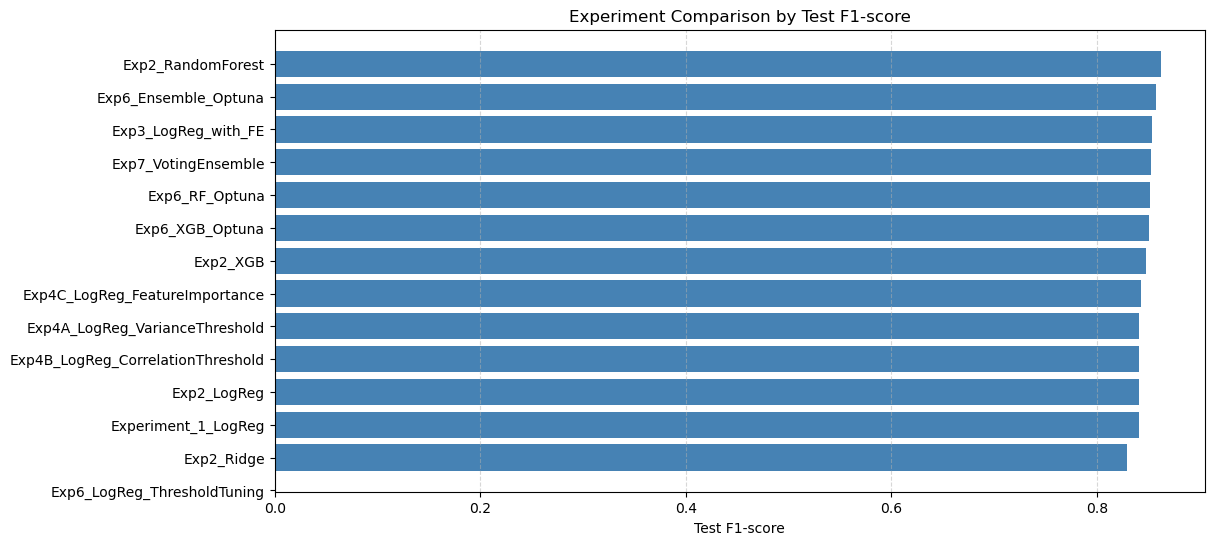

✅ Best Model: Exp2_RandomForest
✅ Test F1: 0.8619528619528619


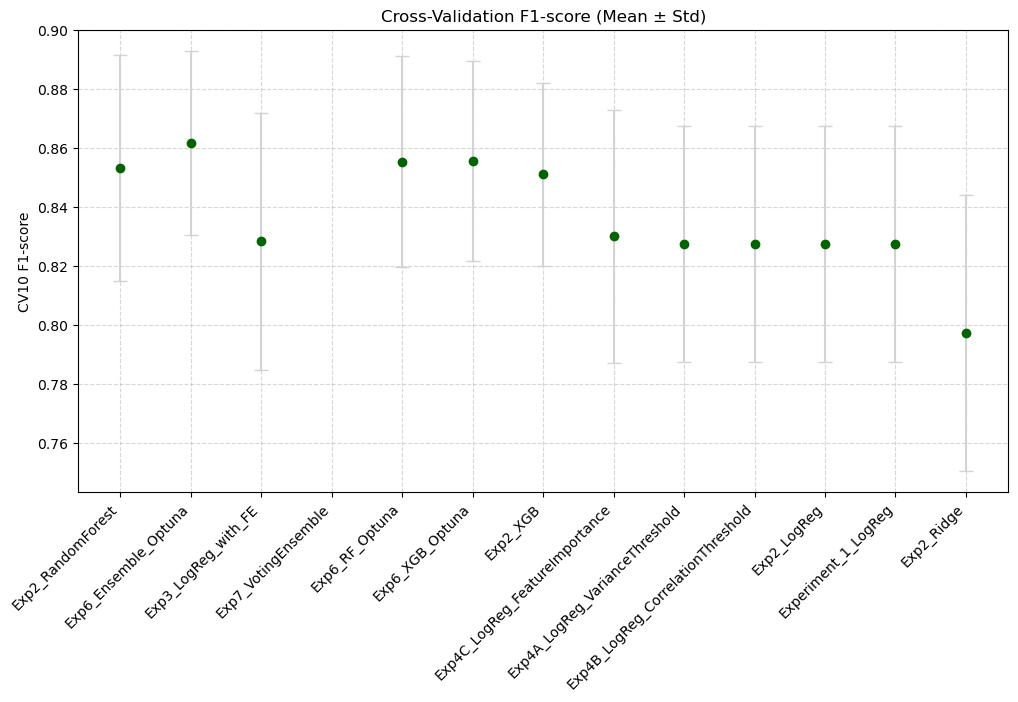

In [6]:
# ---------------------------------------------------------
# Model selection
# ---------------------------------------------------------

from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt

client = MlflowClient()
experiment = client.get_experiment_by_name("Final_Project_Experiments")
experiment_id = experiment.experiment_id

runs = client.search_runs(experiment_ids=[experiment_id])

records = []

for run in runs:
    run_id = run.info.run_id
    name = run.data.tags.get("mlflow.runName", run_id)

    test_f1 = run.data.metrics.get("test_f1")
    cv_mean = run.data.metrics.get("cv10_f1_mean")
    cv_std = run.data.metrics.get("cv10_f1_std")

    records.append({
        "run_name": name,
        "test_f1": test_f1,
        "cv10_f1_mean": cv_mean,
        "cv10_f1_std": cv_std,
        "run_id": run_id
    })

df_results = pd.DataFrame(records)
df_results = df_results.sort_values("test_f1", ascending=False)

df_results


plt.figure(figsize=(12, 6))
plt.barh(df_results["run_name"], df_results["test_f1"], color="steelblue")
plt.xlabel("Test F1-score")
plt.title("Experiment Comparison by Test F1-score")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()



best_row = df_results.iloc[0]
print("✅ Best Model:", best_row["run_name"])
print("✅ Test F1:", best_row["test_f1"])



plt.figure(figsize=(12, 6))
plt.errorbar(
    df_results["run_name"],
    df_results["cv10_f1_mean"],
    yerr=df_results["cv10_f1_std"],
    fmt="o",
    color="darkgreen",
    ecolor="lightgray",
    capsize=5
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CV10 F1-score")
plt.title("Cross-Validation F1-score (Mean ± Std)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()




# We evaluated multiple models and preprocessing strategies across seven experiments. 
# The horizontal bar chart shows that RandomForest (Exp2) achieved the highest test F1-score, 
# followed by XGBoost and a voting ensemble. These results guided our final model selection for deployment.